# Quixo2Vec

In [1]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
%matplotlib inline
from __future__ import print_function
import collections
import math
import numpy as np
import os
import random
import tensorflow as tf
import zipfile
from matplotlib import pylab
from six.moves import range
from six.moves.urllib.request import urlretrieve
from sklearn.manifold import TSNE

Download the data from the source website if necessary.

In [2]:
url = 'http://www.gutenberg.org/cache/epub/2000/'

def maybe_download(filename, expected_bytes):
  """Download a file if not present, and make sure it's the right size."""
  if not os.path.exists(filename):
    filename, _ = urlretrieve(url + filename, filename)
  statinfo = os.stat(filename)
  if statinfo.st_size == expected_bytes:
    print('Found and verified %s' % filename)
  else:
    print(statinfo.st_size)
    raise Exception(
      'Failed to verify ' + filename + '. Can you get to it with a browser?')
  return filename

filename = maybe_download('pg2000.txt', 2198927)

Found and verified text8.zip


Read the data into a string.

In [3]:
def read_data(filename):
  """Extract the first file enclosed in a zip file as a list of words"""
  with open(filename) as f:
    data = tf.compat.as_str(f.read()).split()
  return data
  
words = read_data(filename)
print('Data size %d' % len(words))

Data size 17005207


Build the dictionary and replace rare words with UNK token.

In [4]:
vocabulary_size = 50000

def build_dataset(words):
  count = [['UNK', -1]]
  count.extend(collections.Counter(words).most_common(vocabulary_size - 1))
  dictionary = dict()
  for word, _ in count:
    dictionary[word] = len(dictionary)
  data = list()
  unk_count = 0
  for word in words:
    if word in dictionary:
      index = dictionary[word]
    else:
      index = 0  # dictionary['UNK']
      unk_count = unk_count + 1
    data.append(index)
  count[0][1] = unk_count
  reverse_dictionary = dict(zip(dictionary.values(), dictionary.keys())) 
  return data, count, dictionary, reverse_dictionary

data, count, dictionary, reverse_dictionary = build_dataset(words)
print('Most common words (+UNK)', count[:5])
print('Sample data', data[:10])
del words  # Hint to reduce memory.

Most common words (+UNK) [['UNK', 418391], ('the', 1061396), ('of', 593677), ('and', 416629), ('one', 411764)]
Sample data [5234, 3081, 12, 6, 195, 2, 3134, 46, 59, 156]


### Word2Vec (Skipgram)

Function to generate a training batch for the skip-gram model.

In [5]:
data_index = 0 # this variable acts a a global pointer to the data array. 

def generate_batch_skipgram(batch_size, num_skips, skip_window):
  global data_index
  assert batch_size % num_skips == 0
  assert num_skips <= 2 * skip_window
  batch = np.ndarray(shape=(batch_size), dtype=np.int32)
  labels = np.ndarray(shape=(batch_size, 1), dtype=np.int32)
  span = 2 * skip_window + 1 # [ skip_window target skip_window ]
  buffer = collections.deque(maxlen=span) # sliding window to be moved over the whole data array
  # fill the buffer with the first words from the current window (span)
  for _ in range(span):
    buffer.append(data[data_index])
    data_index = (data_index + 1) % len(data) # modulo just in case we get to the end of the data array
  # we use // because we move slower on the data array than on the batch array, i.e, 
  # as i increases once (we advance one position in data[]), j increases 4 times
  # (we advance 4 positions in batch[]) given that we are repeating the skip_word <num_skip> times
  for i in range(batch_size // num_skips): 
    target = skip_window  # target label at the center of the buffer
    # this is to be filled with 1. the current skip word (we dont want to predict the skip 
    # word using the same skip word as input), and 2. with the words we have already used as labels
    targets_to_avoid = [ skip_window ] 
    for j in range(num_skips):
      while target in targets_to_avoid:
        target = random.randint(0, span - 1) # select randomly an unused word from the skip window
      targets_to_avoid.append(target)
      # the word in position skip_window is the word of the middle of the window (span), which is the 
      # prediction input, so we add it to the input list. i controls the batch and j the offset into the batch
      batch[i * num_skips + j] = buffer[skip_window] 
      labels[i * num_skips + j, 0] = buffer[target] # we add the label to be predicted
    # let's move the sliding window one word to the right
    buffer.append(data[data_index]) # push one in to the back of the queue, the first in the queue pops out
    data_index = (data_index + 1) % len(data)
  return batch, labels

# remember, data contains the keys (indexes of words the in original words string) of common 
# words in the reverse dictionary
print('data:', [reverse_dictionary[di] for di in data[:8]])

# some examples of skipgram datasets
for num_skips, skip_window in [(2, 1), (4, 2)]:
    data_index = 0
    batch, labels = generate_batch_skipgram(batch_size=8, num_skips=num_skips, skip_window=skip_window)
    print('\nwith num_skips = %d and skip_window = %d:' % (num_skips, skip_window))
    print('    batch:', [reverse_dictionary[bi] for bi in batch])
    print('    labels:', [reverse_dictionary[li] for li in labels.reshape(8)])

data: ['anarchism', 'originated', 'as', 'a', 'term', 'of', 'abuse', 'first']

with num_skips = 2 and skip_window = 1:
    batch: ['originated', 'originated', 'as', 'as', 'a', 'a', 'term', 'term']
    labels: ['anarchism', 'as', 'a', 'originated', 'as', 'term', 'of', 'a']

with num_skips = 4 and skip_window = 2:
    batch: ['as', 'as', 'as', 'as', 'a', 'a', 'a', 'a']
    labels: ['anarchism', 'originated', 'a', 'term', 'as', 'originated', 'of', 'term']


Train a skip-gram model.

In [6]:
batch_size = 128
embedding_size = 128 # Dimension of the embedding vector.
skip_window = 1 # How many words to consider left and right.
num_skips = 2 # How many times to reuse an input to generate a label.
# We pick a random validation set to sample nearest neighbors. here we limit the
# validation samples to the words that have a low numeric ID, which by
# construction are also the most frequent. 
valid_size = 16 # Random set of words to evaluate similarity on.
valid_window = 100 # Only pick dev samples in the head of the distribution.
valid_examples = np.array(random.sample(range(valid_window), valid_size))
num_sampled = 64 # Number of negative examples to sample.

graph = tf.Graph()

with graph.as_default(), tf.device('/cpu:0'):

  # Input data.
  train_dataset = tf.placeholder(tf.int32, shape=[batch_size])
  train_labels = tf.placeholder(tf.int32, shape=[batch_size, 1])
  valid_dataset = tf.constant(valid_examples, dtype=tf.int32)
  
  # Variables.
  embeddings = tf.Variable(
    tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0))
  softmax_weights = tf.Variable(
    tf.truncated_normal([vocabulary_size, embedding_size],
                         stddev=1.0 / math.sqrt(embedding_size)))
  softmax_biases = tf.Variable(tf.zeros([vocabulary_size]))
  
  # Model.
  # Look up embeddings for inputs.
  # This method is used similar to fancy indexing in numpy. train_dataset is a list of indexes
  # representing the rows to be retrieved from the embeddings 2D tensor. The resulting rows are
  # the embedding vectors for each input word of the training batch. The vectors are concatenated
  # into a dense tensor of shape (batch_size x embedding_size)
  # just as if we had multiplied a bunch of one hot row vectors with the embedding matrix
  embed = tf.nn.embedding_lookup(embeddings, train_dataset)
  # Compute the softmax loss, using a sample of the negative labels each time.
  # embed is a tensor with shape (batch_size x embedding_size)
  # weights is tensor with shape (vocabulary_size x embedding_size)
  # so I guess what happens below is that embed gets transposed so the shapes match for multiplication
  # output = softmax_weights * embed.T + softmax_biases
  # output is a tensor with shape (vocabulary_size x batch size), i.e. one output column 
  # (probability distribution over the vocabulary) per input word
  loss = tf.reduce_mean(
    tf.nn.sampled_softmax_loss(weights=softmax_weights, biases=softmax_biases, inputs=embed,
                               labels=train_labels, num_sampled=num_sampled, num_classes=vocabulary_size))

  # Optimizer.
  # Note: The optimizer will optimize the softmax_weights AND the embeddings.
  # This is because the embeddings are defined as a variable quantity and the
  # optimizer's `minimize` method will by default modify all variable quantities 
  # that contribute to the tensor it is passed.
  # See docs on `tf.train.Optimizer.minimize()` for more details.
  optimizer = tf.train.AdagradOptimizer(1.0).minimize(loss)
  
  # Compute the similarity between minibatch examples and all embeddings.
  # We use the cosine distance:
  norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keep_dims=True))
  normalized_embeddings = embeddings / norm
  valid_embeddings = tf.nn.embedding_lookup(
    normalized_embeddings, valid_dataset)
  similarity = tf.matmul(valid_embeddings, tf.transpose(normalized_embeddings))

In [8]:
num_steps = 100001

with tf.Session(graph=graph) as session:
  tf.global_variables_initializer().run()
  print('Initialized')
  average_loss = 0
  for step in range(num_steps):
    batch_data, batch_labels = generate_batch_skipgram(
      batch_size, num_skips, skip_window)
    feed_dict = {train_dataset : batch_data, train_labels : batch_labels}
    _, l = session.run([optimizer, loss], feed_dict=feed_dict)
    average_loss += l
    if step % 2000 == 0:
      if step > 0:
        average_loss = average_loss / 2000
      # The average loss is an estimate of the loss over the last 2000 batches.
      print('Average loss at step %d: %f' % (step, average_loss))
      average_loss = 0
    # note that this is expensive (~20% slowdown if computed every 500 steps)
    if step % 10000 == 0:
      sim = similarity.eval()
      for i in range(valid_size):
        valid_word = reverse_dictionary[valid_examples[i]]
        top_k = 8 # number of nearest neighbors
        nearest = (-sim[i, :]).argsort()[1:top_k+1]
        log = 'Nearest to %s:' % valid_word
        for k in range(top_k):
          close_word = reverse_dictionary[nearest[k]]
          log = '%s %s,' % (log, close_word)
        print(log)
  final_embeddings = normalized_embeddings.eval()

Initialized
Average loss at step 0: 8.215173
Nearest to five: rube, frisch, roasted, factorization, dhabi, citigroup, swallow, pows,
Nearest to three: gondwana, searchable, solicit, reunions, comprehend, surpluses, coulter, jugnauth,
Nearest to seven: innocence, poland, darboux, inhabitants, frantic, broker, sipe, rightmost,
Nearest to people: tenn, gwen, fortunately, goblins, curtains, lionheart, rios, amend,
Nearest to has: severity, neg, nouakchott, alejandro, deutschlands, dries, avenging, presto,
Nearest to see: informed, sepp, corte, prophets, methodism, suitors, andorra, paragon,
Nearest to state: kilo, unparalleled, vindicated, meritocratic, lentils, toxicity, emotion, mosul,
Nearest to while: eon, investigative, fillmore, bleeding, triplets, blackadder, innes, evaporation,
Nearest to an: negroes, bedrooms, britons, methodus, hor, oratorios, kops, technological,
Nearest to would: mhz, czechoslovakia, cartridge, differentiation, apparent, asean, photography, renamo,
Nearest to t

In [9]:
num_points = 400

tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000, method='exact')
two_d_embeddings = tsne.fit_transform(final_embeddings[1:num_points+1, :])

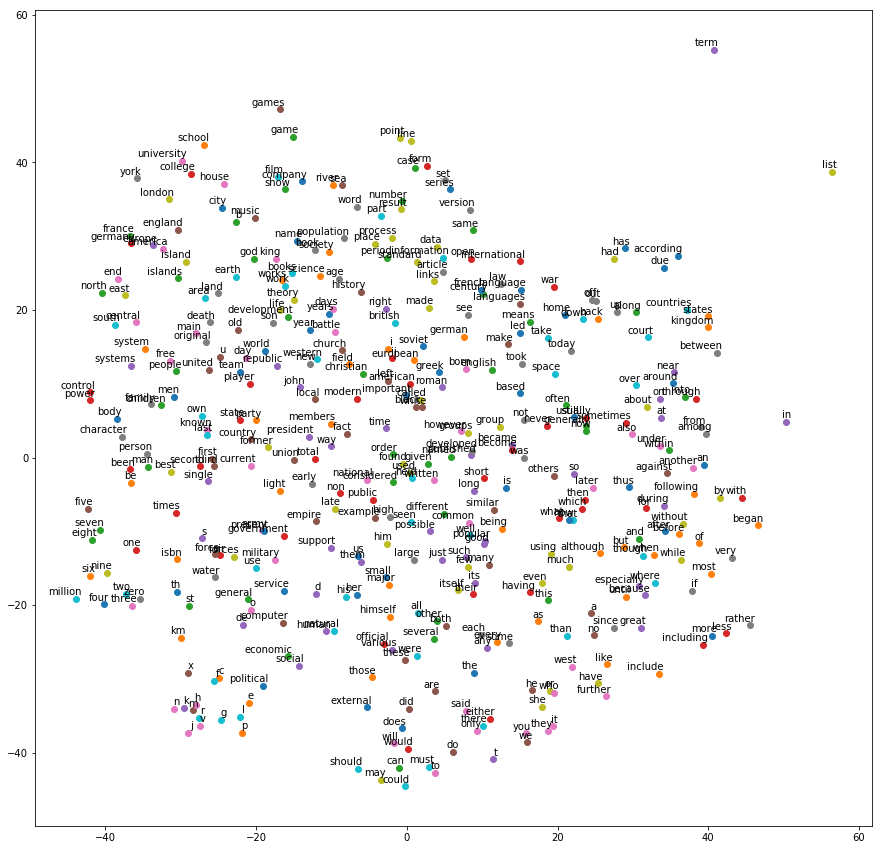

In [10]:
def plot(embeddings, labels):
  assert embeddings.shape[0] >= len(labels), 'More labels than embeddings'
  pylab.figure(figsize=(15,15))  # in inches
  for i, label in enumerate(labels):
    x, y = embeddings[i,:]
    pylab.scatter(x, y)
    pylab.annotate(label, xy=(x, y), xytext=(5, 2), textcoords='offset points',
                   ha='right', va='bottom')
  pylab.show()

words = [reverse_dictionary[i] for i in range(1, num_points+1)]
plot(two_d_embeddings, words)

### CBOW

In [32]:
data_index = 0 # this variable acts a a global pointer to the data array. 

def generate_batch_cbow(batch_size, context_window_size):
  global data_index
  batch = np.ndarray(shape=(batch_size, 2*context_window_size), dtype=np.int32)
  labels = np.ndarray(shape=(batch_size, 1), dtype=np.int32)
  
  span = 2 * context_window_size + 1 # [ context_window label context_window ]
  buffer = collections.deque(maxlen=span) # sliding window to be moved over the whole data array
  # fill the buffer with the first words from the current window (span)
  for _ in range(span):
    buffer.append(data[data_index])
    data_index = (data_index + 1) % len(data) # modulo just in case we get to the end of the data array
  for i in range(batch_size):
    target = context_window_size  # target label at the center of the buffer
    window = []
    for j in range(span):
      if j != target:
        window.append(buffer[j])
    batch[i] = np.array(window)
    labels[i, 0] = buffer[target] # we add the label to be predicted
    # let's move the sliding window one word to the right
    buffer.append(data[data_index]) # push one in to the back of the queue, the first in the queue pops out
    data_index = (data_index + 1) % len(data)
  return batch, labels

# remember, data contains the keys (indexes of words the in original words string) of common 
# words in the reverse dictionary
print('data:', [reverse_dictionary[di] for di in data[:8]])

# some examples of skipgram datasets
for context_window_size in [2, 4]:
    data_index = 0
    batch, labels = generate_batch_cbow(batch_size=8, context_window_size=context_window_size)
    print('\nwith context_window_size = %d:' % (context_window_size))
    print('    batch:', [[reverse_dictionary[bi] for bi in b] for b in batch])
    print('    labels:', [reverse_dictionary[li] for li in labels.reshape(8)])

data: ['anarchism', 'originated', 'as', 'a', 'term', 'of', 'abuse', 'first']

with context_window_size = 2:
    batch: [['anarchism', 'originated', 'a', 'term'], ['originated', 'as', 'term', 'of'], ['as', 'a', 'of', 'abuse'], ['a', 'term', 'abuse', 'first'], ['term', 'of', 'first', 'used'], ['of', 'abuse', 'used', 'against'], ['abuse', 'first', 'against', 'early'], ['first', 'used', 'early', 'working']]
    labels: ['as', 'a', 'term', 'of', 'abuse', 'first', 'used', 'against']

with context_window_size = 4:
    batch: [['anarchism', 'originated', 'as', 'a', 'of', 'abuse', 'first', 'used'], ['originated', 'as', 'a', 'term', 'abuse', 'first', 'used', 'against'], ['as', 'a', 'term', 'of', 'first', 'used', 'against', 'early'], ['a', 'term', 'of', 'abuse', 'used', 'against', 'early', 'working'], ['term', 'of', 'abuse', 'first', 'against', 'early', 'working', 'class'], ['of', 'abuse', 'first', 'used', 'early', 'working', 'class', 'radicals'], ['abuse', 'first', 'used', 'against', 'working', 

Train a CBOW model

In [38]:
batch_size = 128
embedding_size = 128 # Dimension of the embedding vector.
context_window_size = 2 # How many words to consider left and right.
# We pick a random validation set to sample nearest neighbors. here we limit the
# validation samples to the words that have a low numeric ID, which by
# construction are also the most frequent. 
valid_size = 16 # Random set of words to evaluate similarity on.
valid_window = 100 # Only pick dev samples in the head of the distribution.
valid_examples = np.array(random.sample(range(valid_window), valid_size))
num_sampled = 64 # Number of negative examples to sample.

graph = tf.Graph()

with graph.as_default(), tf.device('/cpu:0'):

  # Input data.
  train_dataset = tf.placeholder(tf.int32, shape=[batch_size, 2*context_window_size])
  train_labels = tf.placeholder(tf.int32, shape=[batch_size, 1])
  valid_dataset = tf.constant(valid_examples, dtype=tf.int32)
  
  # Variables.
  embeddings = tf.Variable(
    tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0))
  softmax_weights = tf.Variable(
    tf.truncated_normal([vocabulary_size, embedding_size],
                         stddev=1.0 / math.sqrt(embedding_size)))
  softmax_biases = tf.Variable(tf.zeros([vocabulary_size]))
  
  # Model.
  # Look up embeddings for inputs.
  # This method is used similar to fancy indexing in numpy. train_dataset is a list of indexes
  # representing the rows to be retrieved from the embeddings 2D tensor. The embedding vectors are concatenated
  # into a dense tensor of shape (batch_size x context_window_size x embedding_size)
  embed = tf.nn.embedding_lookup(embeddings, train_dataset)
  # And now according to CBOW, we sum all the embedding vectors to obtain a context embedding
  sum_embed = tf.reduce_sum(embed, 1)
  # Compute the softmax loss, using a sample of the negative labels each time.
  # sum_embed is a tensor with shape (batch_size x embedding_size)
  # weights is tensor with shape (vocabulary_size x embedding_size)
  # so I guess what happens below is that embed gets transposed so the shapes match for multiplication
  # output = softmax_weights * sum_embed.T + softmax_biases
  # output is a tensor with shape (vocabulary_size x batch size), i.e. one output column 
  # (probability distribution over the vocabulary) per input word
  loss = tf.reduce_mean(
    tf.nn.sampled_softmax_loss(weights=softmax_weights, biases=softmax_biases, inputs=sum_embed,
                               labels=train_labels, num_sampled=num_sampled, num_classes=vocabulary_size))

  # Optimizer.
  # Note: The optimizer will optimize the softmax_weights AND the embeddings.
  # This is because the embeddings are defined as a variable quantity and the
  # optimizer's `minimize` method will by default modify all variable quantities 
  # that contribute to the tensor it is passed.
  # See docs on `tf.train.Optimizer.minimize()` for more details.
  optimizer = tf.train.AdagradOptimizer(1.0).minimize(loss)
  
  # Compute the similarity between minibatch examples and all embeddings.
  # We use the cosine distance:
  norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keep_dims=True))
  normalized_embeddings = embeddings / norm
  valid_embeddings = tf.nn.embedding_lookup(
    normalized_embeddings, valid_dataset)
  similarity = tf.matmul(valid_embeddings, tf.transpose(normalized_embeddings))

In [39]:
num_steps = 100001

with tf.Session(graph=graph) as session:
  tf.global_variables_initializer().run()
  print('Initialized')
  average_loss = 0
  for step in range(num_steps):
    batch_data, batch_labels = generate_batch_cbow(
      batch_size, context_window_size)
    feed_dict = {train_dataset : batch_data, train_labels : batch_labels}
    _, l = session.run([optimizer, loss], feed_dict=feed_dict)
    average_loss += l
    if step % 2000 == 0:
      if step > 0:
        average_loss = average_loss / 2000
      # The average loss is an estimate of the loss over the last 2000 batches.
      print('Average loss at step %d: %f' % (step, average_loss))
      average_loss = 0
    # note that this is expensive (~20% slowdown if computed every 500 steps)
    if step % 10000 == 0:
      sim = similarity.eval()
      for i in range(valid_size):
        valid_word = reverse_dictionary[valid_examples[i]]
        top_k = 8 # number of nearest neighbors
        nearest = (-sim[i, :]).argsort()[1:top_k+1]
        log = 'Nearest to %s:' % valid_word
        for k in range(top_k):
          close_word = reverse_dictionary[nearest[k]]
          log = '%s %s,' % (log, close_word)
        print(log)
  final_embeddings = normalized_embeddings.eval()

Initialized
Average loss at step 0: 8.040525
Nearest to new: aptitude, keywork, postmodernist, hobart, thus, twilight, uploads, crannog,
Nearest to but: recruiting, neu, disproving, manned, mercantilists, decimus, khanty, overkill,
Nearest to th: flooding, foreknowledge, milligan, depopulated, grosse, unconfirmed, terra, harmonious,
Nearest to one: ritter, romulus, implosive, ethidium, sibilants, remarking, catering, crick,
Nearest to for: cantigas, perpetuation, clemens, rococo, egg, barns, dumbarton, associative,
Nearest to these: enrollments, acute, visa, massacre, esas, bashir, intensification, coolidge,
Nearest to system: narcolepsy, angora, dayan, tertium, pci, leetspeak, homosexual, animalium,
Nearest to often: tripartite, hellas, representationalism, invited, lets, klansmen, savile, pantheon,
Nearest to from: canning, logicians, gateless, thief, bakunin, surpass, bongo, evaporation,
Nearest to was: alternately, excitable, heaney, vibrato, tights, official, harford, tore,
Neares

In [41]:
num_points = 400

tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000, method='exact')
two_d_embeddings = tsne.fit_transform(final_embeddings[1:num_points+1, :])

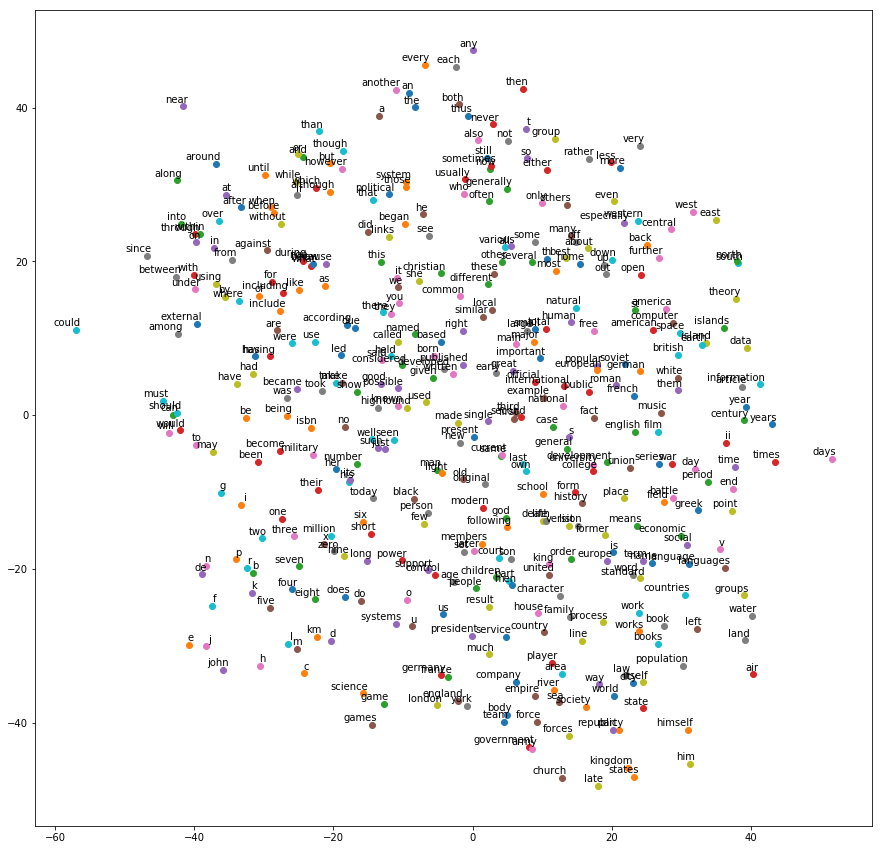

In [42]:
def plot(embeddings, labels):
  assert embeddings.shape[0] >= len(labels), 'More labels than embeddings'
  pylab.figure(figsize=(15,15))  # in inches
  for i, label in enumerate(labels):
    x, y = embeddings[i,:]
    pylab.scatter(x, y)
    pylab.annotate(label, xy=(x, y), xytext=(5, 2), textcoords='offset points',
                   ha='right', va='bottom')
  pylab.show()

words = [reverse_dictionary[i] for i in range(1, num_points+1)]
plot(two_d_embeddings, words)